In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("datos.dat", sep = ",")
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
df = pd.DataFrame({"FECHA" : df["TIMESTAMP"],
                   "TEMP" : df["AirTC_Avg"]
})

df["AÑO"] = df["FECHA"].dt.year
df["MES"] = df["FECHA"].dt.month
df["DIA"] = df["FECHA"].dt.day
df["HORA"] = df["FECHA"].dt.hour
 
df.describe()

,TEMP,AÑO,MES,DIA,HORA
count,40660.000000,40660.000000,40660.000000,40660.000000,40660.000000
mean,23.114218,2018.170708,7.413625,15.807821,11.498524
std,9.059851,0.376259,3.414580,8.759259,6.927122
min,-1.591000,2018.000000,1.000000,1.000000,0.000000
25%,15.960000,2018.000000,6.000000,8.000000,5.000000
50%,24.330000,2018.000000,8.000000,16.000000,11.000000
75%,30.090000,2018.000000,10.000000,23.000000,18.000000
max,45.370000,2019.000000,12.000000,31.000000,23.000000


In [4]:
## Calcular el promedio por hora de la temperatura

hora_anterior = 20
suma = 0
c = 0
temps = []
fecha = []
for i in range(0,len(df)):
    if(df["HORA"][i] == hora_anterior):
        suma = suma + df["TEMP"][i]
        hora_anterior = df["HORA"][i]
        c = c+1
    else:
        temps.append(suma/c)
        fecha.append(df["FECHA"][i])
        suma = df["TEMP"][i]
        hora_anterior = df["HORA"][i]
        c = 1
temps.append(suma/c)
fecha.append(df["FECHA"][i])

In [5]:
## Creo un data frame con los promedios
df2 = pd.DataFrame({"FECHA" : fecha,
                    "TEMP" : temps})
df2["FECHA"] = pd.to_datetime(df2.FECHA)
df2["AÑO"] = df2["FECHA"].dt.year
df2["MES"] = df2["FECHA"].dt.month
df2["DIA"] = df2["FECHA"].dt.day

df2 = df2[df2["FECHA"]>= "2018-11-01"]
df2 = df2.reset_index(drop = True)
df2.head()

,FECHA,TEMP,AÑO,MES,DIA
0,2018-11-01 00:00:00,10.170000,2018,11,1
1,2018-11-01 01:00:00,8.708333,2018,11,1
2,2018-11-01 02:00:00,8.493333,2018,11,1
3,2018-11-01 03:00:00,8.690000,2018,11,1
4,2018-11-01 04:00:00,8.846667,2018,11,1


In [6]:
## Obtiene la unidad de frio acumulada en un dia (UF24) comenzando en el 01 de noviembre
## Ademas obtiene la temperatura maxima y minima de cada dia
suma = 0
sumas = []
fechas2 = []
tmax = -1000
tmin =  1000
tmaxs = []
tmins = []
for i in range(df2["AÑO"][0],df2["AÑO"][len(df2)-1]+1):
    dfnen = df2[df2["AÑO"] == i]
    for j in range(dfnen["MES"][dfnen.index[0]],dfnen["MES"][dfnen.index[len(dfnen)-1]]+1):
        dfmes = dfnen[dfnen["MES"] == j]
        for k in range(dfmes["DIA"][dfmes.index[0]],dfmes["DIA"][dfmes.index[len(dfmes)-1]]+1):
            dfdia = dfmes[dfmes["DIA"] == k]
            for n in dfdia.index:
                if(dfdia["TEMP"][n] > tmax):
                    tmax = dfdia["TEMP"][n]
                if(dfdia["TEMP"][n] < tmin):
                    tmin = dfdia["TEMP"][n]
                if(dfdia["TEMP"][n] < 1.5):
                    continue
                elif(dfdia["TEMP"][n] >= 1.5  and dfdia["TEMP"][n] < 2.5):
                    suma = suma + 0.5
                elif(dfdia["TEMP"][n] >= 2.5  and dfdia["TEMP"][n] < 9.2):
                    suma = suma + 1.0
                elif(dfdia["TEMP"][n] >= 9.2  and dfdia["TEMP"][n] < 12.5):
                    suma = suma + 0.5
                elif(dfdia["TEMP"][n] >= 12.5 and dfdia["TEMP"][n] < 16):
                    continue
                elif(dfdia["TEMP"][n] >= 16   and dfdia["TEMP"][n] < 18):
                    suma = suma - 0.5
                else:
                    suma = suma - 1.0
            fechas2.append(str(i) + " " + str(j) + " " + str(k))
            sumas.append(suma)
            suma = 0
            
            tmaxs.append(tmax)
            tmins.append(tmin)
            tmax = -1000
            tmin =  1000

In [7]:
HF = []
HC = []

for i in range(df2["AÑO"][0],df2["AÑO"][len(df2)-1]+1):
    dfnen = df2[df2["AÑO"] == i]
    for j in range(dfnen["MES"][dfnen.index[0]],dfnen["MES"][dfnen.index[len(dfnen)-1]]+1):
        dfmes = dfnen[dfnen["MES"] == j]
        for k in range(dfmes["DIA"][dfmes.index[0]],dfmes["DIA"][dfmes.index[len(dfmes)-1]]+1):
            dfdia = dfmes[dfmes["DIA"] == k]
            for n in dfdia.index:
                if(0 < dfdia["TEMP"][n] <= 10):
                    HF.append(1)
                    HC.append(0)
                elif(dfdia["TEMP"][n] > 25):
                    HF.append(0)
                    HC.append(1)
                else:
                    HF.append(0)
                    HC.append(0)

In [8]:
df2["HF"] = HF
df2["HC"] = HC

In [9]:
df2["HF24"] = df2.groupby(["AÑO","MES","DIA"])["HF"].transform("sum")
df2["T>25"] = df2.groupby(["AÑO","MES","DIA"])["HC"].transform("sum")
df2["HFE"] = df2["HF24"] - df2["T>25"]

In [10]:
df3 = df2.drop_duplicates(["AÑO","MES","DIA"]).reset_index(drop=True)

In [11]:
df3["UF24"] = sumas
df3 = df3.drop(["AÑO","MES","DIA"],1)#,"HF","HC"],axis = 1)

In [12]:
df3.head()

,FECHA,TEMP,HF,HC,HF24,T>25,HFE,UF24
0,2018-11-01,10.170000,0,0,8,6,2,-0.5
1,2018-11-02,10.970000,0,0,0,8,-8,-8.5
2,2018-11-03,13.141667,0,0,0,8,-8,-9.0
3,2018-11-04,14.073333,0,0,0,8,-8,-11.5
4,2018-11-05,14.880000,0,0,0,8,-8,-8.5


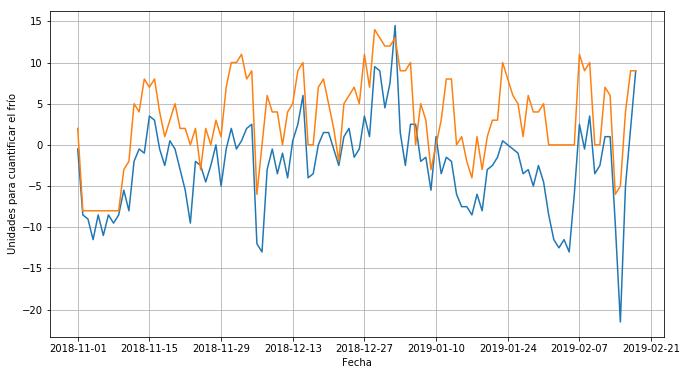

In [24]:
cosas = df3[["UF24","HFE"]]
plt.figure(figsize = (11,6))
plt.plot(df3["FECHA"],cosas)
plt.xlabel("Fecha")
plt.ylabel("Unidades para cuantificar el frío")
plt.grid()
plt.legend()
plt.show()

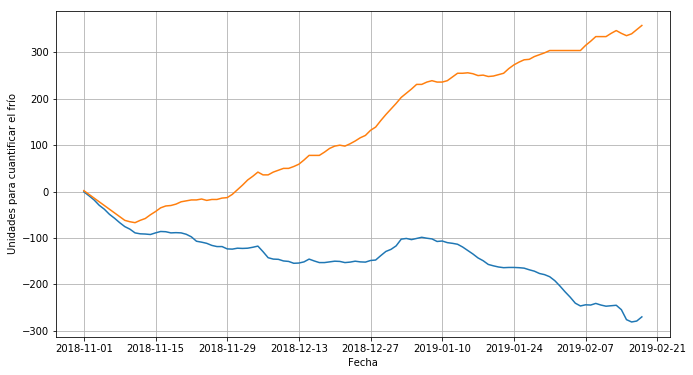

In [25]:
cosas2 = df3[["UF24","HFE"]].cumsum()
plt.figure(figsize = (11,6))
plt.plot(df3["FECHA"],cosas2)
plt.xlabel("Fecha")
plt.ylabel("Unidades para cuantificar el frío")
plt.grid()
plt.legend()
plt.show()